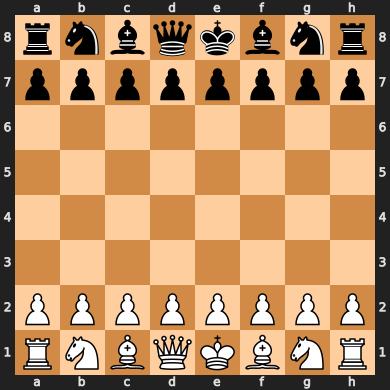

In [213]:
from chess import Board

board = Board("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")
# standard starting position

board

# Possible Moves

### AlphaZero’s Specific Choice

In the AlphaZero paper (“Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm,” 2017), the action space is described as:

- Moves are represented as 73 planes (for move types) × 64 squares (for source positions).
- The 73 planes break down as:
    - 56 queen-move planes: 8 directions × 7 distances.
    - 8 knight-move planes: 8 possible knight moves.
    - 9 promotion planes: 3 move types (straight, capture left, capture right) × 3 underpromotions (rook, bishop, knight; queen promotion is implicit or --handled separately).
- Total actions:
```64 squares × 73 move types = 4672```

This encoding ensures every legal move (including promotions, castling, and en passant) can be mapped to one of the 4672 indices, with illegal or redundant indices masked during training and inference.

### Each players have 16 pieces on the board
> Rook -  ```2 pieces x 4 directions x 7 distances = 2 x 28 actions```\
> Knight - ```2 pieces x 8 directions = 2 x 8 actions```\
> Bishop - ```2 pieces x 4 directions x 7 distances = 2 x 28 actions```\
> Queen - ```1 piece x 8 directions x 7 distances = 1 x 56 actions```\
> King - ```1 piece x (8 directions + 2 Types of Castlings) = 1 x 10 actions```\
> Pawn - ```8 pieces x (2 forward moves + 2 capture moves + 2 En Passant + Queen's 56 actions + Knight's 8 actions) = 8 x 70 actions```\
(Having potential to gain Rook, Bishop, Queen or Knight's move)

> Total possible actions per player: ```2x28 + 2x8 + 2x28 + 1x56 + 1x10 + 8x82 = 56 + 16 + 56 + 56 + 10 + 560 = 754 actions```

- However, this is the theoretical maximum. In practice, many moves are blocked by other pieces or would put the king in check.

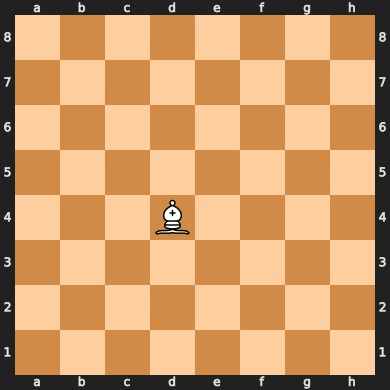

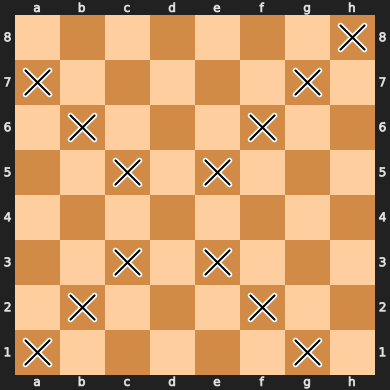

In [214]:
from chess import *
from IPython.display import display

# ROOK, BISHOP, KNIGHT, QUEEN, KING, PAWN
piece = Piece(BISHOP, WHITE)

board = Board()
board.clear()
board.set_piece_at(D4, piece)

sqaureset = SquareSet(map(lambda x: x.to_square, board.legal_moves))
display(board, sqaureset)

### Display Board with Drawing Numbers, Multiple Display in a Row

In [188]:
import chess
import chess.svg
from IPython.display import SVG, display, HTML

def draw_numbers_on_board(
    square_to_number_map: dict[chess.Square, str],
    board: chess.Board | None = None,
    text_color: str = "red",
    font_size: int = 32,
    board_size: int = 400,
    **kwargs
) -> str:
    """
    Generates an SVG representation of a chess board with numbers/text drawn on specified squares.

    Args:
        square_to_number_map: A dictionary where keys are chess.Square objects and
                              values are the strings (numbers) to draw on those squares.
        board: An optional chess.Board object. Defaults to the standard starting position.
        text_color: The color of the text to be drawn.
        font_size: The font size of the text.
        board_size: The size of the SVG board in pixels.
        **kwargs: Additional keyword arguments to pass to chess.svg.board
                  (e.g., squares, arrows, orientation).

    Returns:
        An SVG string representing the board with the numbers drawn on it.
    """
    if board is None:
        board = chess.Board()

    # Generate the base SVG using any additional options passed via kwargs
    svg_string = chess.svg.board(board=board, size=board_size, **kwargs)
    square_size = chess.svg.SQUARE_SIZE
    
    all_text_elements = ""

    for square, number_to_draw in square_to_number_map.items():
        # Calculate SVG coordinates for the center of the square
        file_index = chess.square_file(square)
        rank_index = 7 - chess.square_rank(square)  # SVG y-coordinate increases downwards
        x_coord = file_index * square_size + square_size / 2 - 7 + square_size * 0.5
        y_coord = rank_index * square_size + square_size / 2 - 6 + square_size * 0.5

        # Create the SVG text element
        # Using dominant-baseline and text-anchor for centering
        text_element = (
            f'<text x="{x_coord}" y="{y_coord}" font-size="{font_size}" '
            f'fill="{text_color}" text-anchor="middle" dominant-baseline="middle">'
            f'{number_to_draw}</text>'
        )
        all_text_elements += text_element

    # Inject all text elements into the SVG before the closing tag
    closing_tag_index = svg_string.rfind('</svg>')
    if closing_tag_index != -1:
        modified_svg = svg_string[:closing_tag_index] + all_text_elements + svg_string[closing_tag_index:]
    else:
        # Fallback if </svg> isn't found
        modified_svg = svg_string + all_text_elements

    return SVG(modified_svg)

def display_svgs_horizontally(svg_list: list[str]):
    """
    Displays a list of SVG strings horizontally in a Jupyter cell using CSS Flexbox.

    Args:
        svg_list: A list where each element is an SVG string.
    """
    if not svg_list:
        print("No SVGs provided to display.")
        return

    # Ensure items in the list are strings
    valid_svg_strings = []
    for i, item in enumerate(svg_list):
        if isinstance(item, str):
            valid_svg_strings.append(item)
        else:
            # Attempt to get the SVG string if it's an SVG object
            try:
                # IPython.display.SVG stores data in _repr_svg_() or .data
                if hasattr(item, '_repr_svg_'):
                    svg_data = item._repr_svg_()
                    if isinstance(svg_data, str):
                         valid_svg_strings.append(svg_data)
                         continue # Skip to next item
                elif hasattr(item, 'data') and isinstance(item.data, str):
                     valid_svg_strings.append(item.data)
                     continue # Skip to next item

            except Exception as e:
                 print(f"Warning: Item {i} is not a valid SVG string or SVG object. Skipping. Error: {e}")

            print(f"Warning: Item {i} is not an SVG string ({type(item)}). Skipping.")


    if not valid_svg_strings:
        print("No valid SVG strings found in the list.")
        return

    # Create div items for each SVG string
    svg_items = "".join([f'<div style="display: inline-block; margin-right: 10px;">{svg_str}</div>' for svg_str in valid_svg_strings])

    # Construct the HTML using a flex container
    html_content = f'<div style="display: flex; flex-wrap: wrap;">{svg_items}</div>'

    # print("\\n--- Checking generated Flexbox HTML ---")
    # print(html_content[:400] + "...") # Optional debug print

    print("\\n--- Attempting to display horizontally using Flexbox ---")
    display(HTML(html_content))

### Universal Chess Interface (UCI) to Action ID 

In [173]:
import chess
from typing import Optional

# return [1 to 28]
def uci_to_rook_action_id(uci_move: str) -> Optional[int]:
    """
    Calculates the action ID (1-28) for a given rook UCI move string.

    Returns the ID if the move is a valid rook move pattern (horizontal or vertical),
    otherwise returns None.

    ID Scheme (Relative, Clockwise, Shortest First, 1-based):
    - North (1-7)
    - East  (8-14)
    - South (15-21)
    - West  (22-28)

    Args:
        uci_move: The move string in UCI format (e.g., "a1a8", "d4h4").

    Returns:
        The action ID (int from 1 to 28) or None if the move is not a
        valid rook move pattern.
    """
    if len(uci_move) != 4:
        # Basic validation
        return None

    try:
        start_sq = chess.parse_square(uci_move[0:2])
        end_sq = chess.parse_square(uci_move[2:4])
    except ValueError:
        # Invalid square notation
        return None

    start_file = chess.square_file(start_sq)
    start_rank = chess.square_rank(start_sq)
    end_file = chess.square_file(end_sq)
    end_rank = chess.square_rank(end_sq)

    file_change = end_file - start_file
    rank_change = end_rank - start_rank

    # Base IDs for each direction (distance 1)
    base_ids = {
        "N": 1,
        "E": 8,
        "S": 15,
        "W": 22
    }

    action_id = None

    # Check for horizontal or vertical movement (must be one or the other, not both, not zero)
    if file_change == 0 and rank_change != 0: # Vertical move
        distance = abs(rank_change)
        if rank_change > 0: # North
            action_id = base_ids["N"] + distance - 1
        else: # South
            action_id = base_ids["S"] + distance - 1
    elif rank_change == 0 and file_change != 0: # Horizontal move
        distance = abs(file_change)
        if file_change > 0: # East
            action_id = base_ids["E"] + distance - 1
        else: # West
            action_id = base_ids["W"] + distance - 1
    # else: Not a valid rook move (diagonal or no move) -> action_id remains None

    # Validate the calculated ID is within the expected range (1-28)
    if action_id is not None and 1 <= action_id <= 28:
         # Additional check: Ensure the calculated distance matches the range for the direction
         max_dist_for_id = 0
         if 1 <= action_id <= 7: max_dist_for_id = 7 # N
         elif 8 <= action_id <= 14: max_dist_for_id = 7 # E
         elif 15 <= action_id <= 21: max_dist_for_id = 7 # S
         elif 22 <= action_id <= 28: max_dist_for_id = 7 # W

         if distance <= max_dist_for_id:
             return action_id
         else:
             return None # Distance doesn't make sense for the derived ID range
    else:
         return None # Not a valid rook move pattern or ID out of range

# return [1 to 8]
def uci_to_knight_action_id(uci_move: str) -> Optional[int]:
    """
    Calculates the action ID (1-8) for a given knight UCI move string.

    Returns the ID if the move is a valid knight L-shape move pattern,
    otherwise returns None.

    ID Scheme (Relative, Clockwise from NNE, 1-based):
    1: NNE (+1f, +2r)    5: SSW (-1f, -2r)
    2: ENE (+2f, +1r)    6: WSW (-2f, -1r)
    3: ESE (+2f, -1r)    7: WNW (-2f, +1r)
    4: SSE (+1f, -2r)    8: NNW (-1f, +2r)

    Args:
        uci_move: The move string in UCI format (e.g., "g1f3").

    Returns:
        The action ID (int from 1 to 8) or None if the move is not a
        valid knight move pattern.
    """
    if len(uci_move) != 4:
        return None

    try:
        start_sq = chess.parse_square(uci_move[0:2])
        end_sq = chess.parse_square(uci_move[2:4])
    except ValueError:
        return None

    start_file = chess.square_file(start_sq)
    start_rank = chess.square_rank(start_sq)
    end_file = chess.square_file(end_sq)
    end_rank = chess.square_rank(end_sq)

    file_change = end_file - start_file
    rank_change = end_rank - start_rank

    # Define knight moves relative offsets (file_change, rank_change) and their IDs
    knight_move_patterns = {
        (1, 2): 1,  # NNE
        (2, 1): 2,  # ENE
        (2, -1): 3, # ESE
        (1, -2): 4, # SSE
        (-1, -2): 5,# SSW
        (-2, -1): 6,# WSW
        (-2, 1): 7, # WNW
        (-1, 2): 8  # NNW
    }

    move_tuple = (file_change, rank_change)

    return knight_move_patterns.get(move_tuple) # Returns ID if found, else None

# return [1 to 28]
def uci_to_bishop_action_id(uci_move: str) -> Optional[int]:
    """
    Calculates the action ID (1-28) for a given bishop UCI move string.

    Returns the ID if the move is a valid diagonal move pattern,
    otherwise returns None.

    ID Scheme (Relative, Clockwise from NE, Shortest First, 1-based):
    - NE (1-7): dist 1 = ID 1, dist 7 = ID 7 (+f, +r)
    - SE (8-14): dist 1 = ID 8, dist 7 = ID 14 (+f, -r)
    - SW (15-21): dist 1 = ID 15, dist 7 = ID 21 (-f, -r)
    - NW (22-28): dist 1 = ID 22, dist 7 = ID 28 (-f, +r)

    Args:
        uci_move: The move string in UCI format (e.g., "c1g5").

    Returns:
        The action ID (int from 1 to 28) or None if the move is not a
        valid bishop move pattern.
    """
    if len(uci_move) != 4:
        return None

    try:
        start_sq = chess.parse_square(uci_move[0:2])
        end_sq = chess.parse_square(uci_move[2:4])
    except ValueError:
        return None

    start_file = chess.square_file(start_sq)
    start_rank = chess.square_rank(start_sq)
    end_file = chess.square_file(end_sq)
    end_rank = chess.square_rank(end_sq)

    file_change = end_file - start_file
    rank_change = end_rank - start_rank

    # Check for diagonal movement (absolute change must be equal and non-zero)
    if abs(file_change) != abs(rank_change) or file_change == 0:
        return None

    distance = abs(file_change) # or abs(rank_change)

    # Base IDs for each direction (distance 1)
    base_ids = {
        "NE": 1,  # (+f, +r)
        "SE": 8,  # (+f, -r)
        "SW": 15, # (-f, -r)
        "NW": 22  # (-f, +r)
    }

    action_id = None

    if file_change > 0 and rank_change > 0: # NE
        action_id = base_ids["NE"] + distance - 1
    elif file_change > 0 and rank_change < 0: # SE
        action_id = base_ids["SE"] + distance - 1
    elif file_change < 0 and rank_change < 0: # SW
        action_id = base_ids["SW"] + distance - 1
    elif file_change < 0 and rank_change > 0: # NW
        action_id = base_ids["NW"] + distance - 1

    # Validate ID range (implicitly checks distance <= 7)
    if action_id is not None and 1 <= action_id <= 28:
        return action_id
    else:
        return None # Should not happen if logic above is correct

# return [1 to 56]
def uci_to_queen_action_id(uci_move: str) -> Optional[int]:
    """
    Calculates the action ID (1-56) for a given queen UCI move string.

    Returns the ID if the move is a valid rook or bishop move pattern,
    otherwise returns None. Rook moves get IDs 1-28, Bishop moves 29-56.

    ID Scheme:
    - Rook Moves (1-28): See uci_to_rook_action_id documentation.
    - Bishop Moves (29-56): Bishop pattern offset by 28.
        - NE (29-35): dist 1 = ID 29, dist 7 = ID 35
        - SE (36-42): dist 1 = ID 36, dist 7 = ID 42
        - SW (43-49): dist 1 = ID 43, dist 7 = ID 49
        - NW (50-56): dist 1 = ID 50, dist 7 = ID 56

    Args:
        uci_move: The move string in UCI format (e.g., "d1d8", "d1h5").

    Returns:
        The action ID (int from 1 to 56) or None if the move is not a
        valid queen move pattern.
    """
    # Try interpreting as a Rook move first
    rook_id = uci_to_rook_action_id(uci_move)
    if rook_id is not None:
        return rook_id # IDs 1-28

    # If not a rook move, try interpreting as a Bishop move
    bishop_id_raw = uci_to_bishop_action_id(uci_move)
    if bishop_id_raw is not None:
        # Offset the raw bishop ID (1-28) to the queen's range (29-56)
        return bishop_id_raw + 28

    # If it's neither a valid rook nor bishop pattern, return None
    return None

# return [1 to 8]
def uci_to_king_action_id(uci_move: str) -> Optional[int]:
    """
    Calculates the action ID (1-8) for a given king UCI move string
    (excluding castling).

    Returns the ID if the move is a valid single-step move pattern
    (horizontal, vertical, or diagonal), otherwise returns None.

    ID Scheme (Relative, Clockwise from N, 1-based):
    1: N  (+0f, +1r)    5: S  (+0f, -1r)
    2: NE (+1f, +1r)    6: SW (-1f, -1r)
    3: E  (+1f, +0r)    7: W  (-1f, +0r)
    4: SE (+1f, -1r)    8: NW (-1f, +1r)

    Note: This does *not* identify castling moves (e.g., "e1g1").

    Args:
        uci_move: The move string in UCI format (e.g., "e1e2").

    Returns:
        The action ID (int from 1 to 8) or None if the move is not a
        valid single-step king move pattern.
    """
    if len(uci_move) != 4:
        return None

    try:
        start_sq = chess.parse_square(uci_move[0:2])
        end_sq = chess.parse_square(uci_move[2:4])
    except ValueError:
        return None

    start_file = chess.square_file(start_sq)
    start_rank = chess.square_rank(start_sq)
    end_file = chess.square_file(end_sq)
    end_rank = chess.square_rank(end_sq)

    file_change = end_file - start_file
    rank_change = end_rank - start_rank

    # Check if it's a single step move (max change of 1 in any direction)
    if abs(file_change) > 1 or abs(rank_change) > 1:
        return None
    # Check if there was any move at all
    if file_change == 0 and rank_change == 0:
         return None

    # Define king moves relative offsets (file_change, rank_change) and their IDs
    king_move_patterns = {
        (0, 1): 1,   # N
        (1, 1): 2,   # NE
        (1, 0): 3,   # E
        (1, -1): 4,  # SE
        (0, -1): 5,  # S
        (-1, -1): 6, # SW
        (-1, 0): 7,  # W
        (-1, 1): 8   # NW
    }

    move_tuple = (file_change, rank_change)

    return king_move_patterns.get(move_tuple) # Returns ID if found, else None

# return [1 to 62]
def uci_to_pawn_action_id(uci_move: str) -> Optional[int]:
    """
    Calculates the action ID for a given pawn UCI move string, including promotions.

    Maps non-promoting moves to corresponding Queen action IDs (1-56).
    Assigns unique IDs (57-62) for Queen/Knight promotions.

    ID Scheme:
    - Non-Promotion (1-56): Mapped to Queen IDs based on direction/distance.
        - Fwd 1: Queen N/S dist 1 (ID 1 / 15)
        - Fwd 2: Queen N/S dist 2 (ID 2 / 16) - Only from start rank
        - Cap L/R: Queen diag dist 1 (IDs 29/50 / 36/43) - Incl. En Passant target
    - Promotion (57-62):
        - Fwd -> Q: 57 | Cap L -> Q: 58 | Cap R -> Q: 59
        - Fwd -> N: 60 | Cap L -> N: 61 | Cap R -> N: 62

    Args:
        uci_move: The move string in UCI format (e.g., "e2e4", "e7e8q", "d5xe6").
                  Handles standard captures 'x' and promotion char.

    Returns:
        The action ID (int from 1 to 62) or None if the move is not a
        valid pawn move pattern according to the scheme.
    """
    # Clean up UCI notation (remove 'x', '+', '#')
    clean_uci = uci_move.replace('x', '').replace('+', '').replace('#', '')

    if not (4 <= len(clean_uci) <= 5):
        return None # Must be like 'e2e4' or 'e7e8q'

    try:
        start_sq = chess.parse_square(clean_uci[0:2])
        end_sq = chess.parse_square(clean_uci[2:4])
        promotion_piece = clean_uci[4] if len(clean_uci) == 5 else None
    except ValueError:
        return None # Invalid square or promotion char format

    start_file = chess.square_file(start_sq)
    start_rank = chess.square_rank(start_sq)
    end_file = chess.square_file(end_sq)
    end_rank = chess.square_rank(end_sq)

    file_change = end_file - start_file
    rank_change = end_rank - start_rank

    # Determine player color based on start rank (simple heuristic)
    is_white_move = start_rank < 4 # Pawns start on ranks 1/6

    # --- Promotion Moves ---
    if promotion_piece:
        # Check if target rank is promotion rank
        is_valid_promo_rank = (is_white_move and end_rank == 7) or \
                              (not is_white_move and end_rank == 0)
        if not is_valid_promo_rank:
            return None # Promotion attempted from non-promotion rank

        promo_target = promotion_piece.lower()
        if promo_target not in ['q', 'n']:
             # Only handling Q/N promotions per user request
             # (Could add 'r', 'b' if needed with more IDs)
             return None

        # Determine move type (forward or capture)
        if file_change == 0 and abs(rank_change) == 1: # Forward move
            if promo_target == 'q': return 57
            if promo_target == 'n': return 60
        elif abs(file_change) == 1 and abs(rank_change) == 1: # Capture move
             # Check if capture direction matches color
             correct_capture_rank_change = (is_white_move and rank_change == 1) or \
                                           (not is_white_move and rank_change == -1)
             if not correct_capture_rank_change: return None

             is_capture_left = (is_white_move and file_change == -1) or \
                               (not is_white_move and file_change == -1) # file decreases = Left for White POV? No, depends. file_change<0 is West.

             # Let's use absolute file change for L/R designation relative to pawn's perspective
             # Capture Left means target file < start file for White, target file > start file for Black?
             # Let's use the file_change directly: < 0 is West (Left Capture for White, Right for Black)
             # > 0 is East (Right Capture for White, Left for Black)

             # Map based on standard action IDs for captures: NW/NE for White, SW/SE for Black
             is_capture_west = file_change < 0
             # is_capture_east = file_change > 0 # Unused

             if is_capture_west: # Capture Left (White NW, Black SW?) - Let's stick to simple L/R
                 # Capture Left: file_change = -1 for White, +1 for Black? No, that's board relative.
                 # Let's map to file change: -1 (W) and +1 (E)
                 if file_change == -1: # Capture West
                      if promo_target == 'q': return 58 # Assume Cap L -> Q maps to file_change < 0
                      if promo_target == 'n': return 61 # Assume Cap L -> N maps to file_change < 0
                 elif file_change == 1: # Capture East
                      if promo_target == 'q': return 59 # Assume Cap R -> Q maps to file_change > 0
                      if promo_target == 'n': return 62 # Assume Cap R -> N maps to file_change > 0
        else:
            return None # Invalid move pattern for promotion

    # --- Non-Promotion Moves ---
    else:
        # Check not ending on promotion rank
        is_promo_rank = (is_white_move and end_rank == 7) or \
                        (not is_white_move and end_rank == 0)
        if is_promo_rank:
             return None # Non-promotion move ending on promotion rank is invalid UCI

        # Check Forward Moves
        if file_change == 0:
            if is_white_move: # White moves North (rank increases)
                if rank_change == 1: # Forward 1
                     # Map to Queen N dist 1
                     return uci_to_queen_action_id(uci_move) # Should return 1
                elif rank_change == 2: # Forward 2
                     if start_rank == 1: # Must be from starting rank
                          # Map to Queen N dist 2
                          return uci_to_queen_action_id(uci_move) # Should return 2
                     else: return None # Invalid double step
                else: return None # Invalid forward move distance
            else: # Black moves South (rank decreases)
                if rank_change == -1: # Forward 1
                     # Map to Queen S dist 1
                     return uci_to_queen_action_id(uci_move) # Should return 15
                elif rank_change == -2: # Forward 2
                     if start_rank == 6: # Must be from starting rank
                          # Map to Queen S dist 2
                          return uci_to_queen_action_id(uci_move) # Should return 16
                     else: return None # Invalid double step
                else: return None # Invalid forward move distance

        # Check Capture Moves (Diagonal)
        elif abs(file_change) == 1:
             correct_rank_change = (is_white_move and rank_change == 1) or \
                                   (not is_white_move and rank_change == -1)
             if correct_rank_change:
                  # Map to Queen diagonal dist 1
                  return uci_to_queen_action_id(uci_move) # e.g., e4xf5 -> 29, d5xe6 -> 50
             else:
                  return None # Invalid diagonal move distance/direction
        else:
            return None # Not a valid pawn move pattern (e.g., sideways)

    return None # Should be unreachable if all cases handled


### Visualize All Actions on the Board with Local Action ID

In [215]:
import chess
from typing import Iterator, Dict, Optional

# Assume all uci_to_*_action_id functions (Rook, Knight, Bishop, Queen, King, Pawn)
# are defined correctly above this point.

def get_action_id_for_piece(uci: str, piece_type: chess.PieceType) -> Optional[int]:
    """Helper function to call the correct uci_to_*_action_id function."""
    if piece_type == chess.ROOK:
        return uci_to_rook_action_id(uci)
    elif piece_type == chess.KNIGHT:
        return uci_to_knight_action_id(uci)
    elif piece_type == chess.BISHOP:
        return uci_to_bishop_action_id(uci)
    elif piece_type == chess.QUEEN:
        return uci_to_queen_action_id(uci)
    elif piece_type == chess.KING:
        # Special handling for castling might be needed depending on action space definition
        # For now, using the standard king move ID function which ignores castling UCI
        king_id = uci_to_king_action_id(uci)
        # Check if it looks like castling based on UCI (e.g., e1g1)
        if king_id is None:
            try:
                move = chess.Move.from_uci(uci)
                if chess.is_castling(move):
                    # Decide how to represent castling ID if needed. Return None for now.
                    return None
            except ValueError: # Invalid UCI
                return None
        return king_id
    elif piece_type == chess.PAWN:
        return uci_to_pawn_action_id(uci)
    else:
        return None # Should not happen for standard pieces

def board_moves_to_action_ids(
    board: chess.Board,
    moves: Iterator[chess.Move],
    target_piece_type: chess.PieceType
) -> Dict[chess.Square, int]:
    """
    Generates a map from destination squares to action IDs for legal moves
    of a specific piece type on the board.

    Args:
        board: The current chess.Board state.
        moves: An iterator of legal chess.Move objects for the current board state.
        target_piece_type: The chess.PieceType to filter moves for (e.g., chess.ROOK).

    Returns:
        A dictionary mapping the destination square (chess.Square) of each valid move
        by the target piece type to its calculated action ID (int).
    """
    dest_square_to_action_id: Dict[chess.Square, int] = {}

    for move in moves:
        # Determine the type of the piece being moved
        piece_at_from_sq = board.piece_type_at(move.from_square)

        # Check if the piece type matches the target type
        if piece_at_from_sq == target_piece_type:
            # Get the action ID using the correct function
            action_id = get_action_id_for_piece(move.uci(), target_piece_type)

            if action_id is not None:
                # Map the destination square to the action ID
                dest_square_to_action_id[move.to_square] = action_id

    return dest_square_to_action_id


In [216]:
board = chess.Board()

board.clear()
board.set_piece_at(chess.A1, chess.Piece(chess.ROOK, chess.WHITE))
svg1 = draw_numbers_on_board(board_moves_to_action_ids(board, board.legal_moves, chess.ROOK), board=board, board_size=300)

board.clear()
board.set_piece_at(chess.H8, chess.Piece(chess.ROOK, chess.WHITE))
svg2 = draw_numbers_on_board(board_moves_to_action_ids(board, board.legal_moves, chess.ROOK), board=board, board_size=300)

board.clear()
board.set_piece_at(chess.D4, chess.Piece(chess.ROOK, chess.WHITE))
svg3 = draw_numbers_on_board(board_moves_to_action_ids(board, board.legal_moves, chess.ROOK), board=board, board_size=300)

display_svgs_horizontally([svg1, svg2, svg3])

\n--- Attempting to display horizontally using Flexbox ---


In [217]:
board = chess.Board()

board.clear()
board.set_piece_at(chess.E1, chess.Piece(chess.BISHOP, chess.WHITE))
svg1 = draw_numbers_on_board(board_moves_to_action_ids(board, board.legal_moves, chess.BISHOP), board=board, board_size=300)

board.clear()
board.set_piece_at(chess.A6, chess.Piece(chess.BISHOP, chess.WHITE))
svg2 = draw_numbers_on_board(board_moves_to_action_ids(board, board.legal_moves, chess.BISHOP), board=board, board_size=300)

board.clear()
board.set_piece_at(chess.D4, chess.Piece(chess.BISHOP, chess.WHITE))
svg3 = draw_numbers_on_board(board_moves_to_action_ids(board, board.legal_moves, chess.BISHOP), board=board, board_size=300)

display_svgs_horizontally([svg1, svg2, svg3])

\n--- Attempting to display horizontally using Flexbox ---
